In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from xgboost import XGBRegressor
from scikit_posthocs import posthoc_dunn
from sklearn.model_selection import train_test_split
from scipy.stats import kruskal
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import RepeatedKFold, cross_val_score
from scipy import stats
from catboost import CatBoostRegressor
from statsmodels.graphics.gofplots import qqplot
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [2]:
pip install scikit-posthocs


[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
marketing_df= pd.read_csv("/Users/pawanbtw/Downloads/WA_Marketing-Campaign.csv")

In [4]:
marketing_df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


In [5]:
def check_df(dataframe, head = 5):
    print("----------Shape----------")
    print(dataframe.shape)
    print("----------Data Types----------")
    print(dataframe.dtypes)
    print("----------Null Values----------")
    print(dataframe.isnull().sum())
    print("----------Quantiles----------")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    
check_df(marketing_df)

----------Shape----------
(548, 7)
----------Data Types----------
MarketID              int64
MarketSize           object
LocationID            int64
AgeOfStore            int64
Promotion             int64
week                  int64
SalesInThousands    float64
dtype: object
----------Null Values----------
MarketID            0
MarketSize          0
LocationID          0
AgeOfStore          0
Promotion           0
week                0
SalesInThousands    0
dtype: int64
----------Quantiles----------
                  count        mean         std    min     0%       5%    50%  \
MarketID          548.0    5.715328    2.877001   1.00   1.00   1.0000    6.0   
LocationID        548.0  479.656934  287.973679   1.00   1.00   7.3500  504.0   
AgeOfStore        548.0    8.503650    6.638345   1.00   1.00   1.0000    7.0   
Promotion         548.0    2.029197    0.810729   1.00   1.00   1.0000    2.0   
week              548.0    2.500000    1.119055   1.00   1.00   1.0000    2.5   
SalesInTh

- **Shape:** The dataset contains 548 rows and 7 columns.
- **Data Types:** 
  - `MarketID`, `LocationID`, `AgeOfStore`, `Promotion`, `week`: Integer (`int64`)
  - `MarketSize`: Object (categorical)
  - `SalesInThousands`: Float (`float64`)
- **Null Values:** There are no missing values in the dataset.
- **Quantiles:**
  - **MarketID:** Values range from 1 to 10.
  - **LocationID:** Ranges from 1 to 920, with a median of 504.
  - **AgeOfStore:** Ranges from 1 to 28

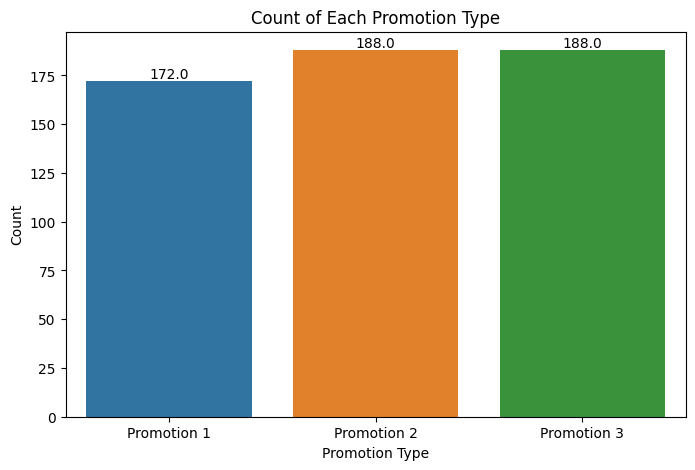

In [6]:
# Bar plot for the count of each promotion
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='Promotion', data=marketing_df)
plt.title('Count of Each Promotion Type')
plt.xlabel('Promotion Type')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=['Promotion 1', 'Promotion 2', 'Promotion 3'])

# Add counts on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.show()

We confirm that each promotion type has a similar number of observations, which ensures fair comparisons and valid results.

A balanced distribution is key to drawing reliable insights when comparing the effectiveness of different promotions.

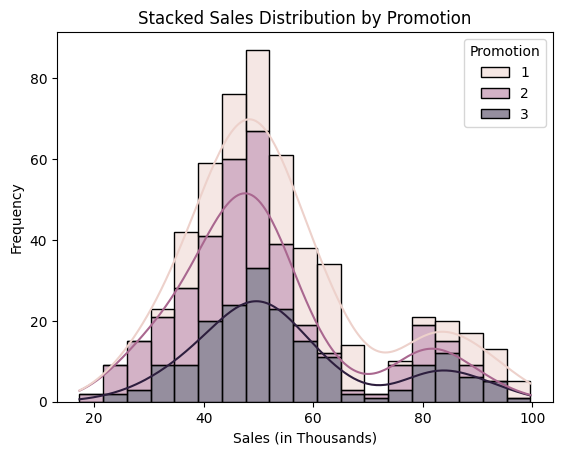

In [7]:
# Plotting histogram with KDE
sns.histplot(data=marketing_df, x='SalesInThousands', hue='Promotion', multiple='stack', kde=True)
plt.title('Stacked Sales Distribution by Promotion')
plt.xlabel('Sales (in Thousands)')
plt.ylabel('Frequency')
plt.show()

### Stacked Sales Distribution by Promotion

This plot visualizes the distribution of sales (in thousands) for each promotion type in the A/B testing experiment:

- **Purpose**: To compare how sales are distributed across the three promotions.
- **Distribution Overlap**: The stacked histogram and density curves reveal the frequency and distribution patterns for each promotion.
- **Insights**:
  - Promotion 1 has a higher concentration around 40-60k in sales.
  - Promotion 2 shows a wider spread with a peak around 50-70k.
  - Promotion 3 appears more spread out, with consistent sales in the 30-80k range.

This visualization helps assess which promotions are performing similarly and which show distinct sales patterns.


Levels for MarketID:
[ 1  2  3  4  5  6  7  8  9 10]
--------------------------------------------------
Levels for MarketSize:
['Medium' 'Small' 'Large']
--------------------------------------------------
Levels for LocationID:
[  1   2   3   4   5   6   7   8   9  10  11  12  13 101 102 103 104 105
 106 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 301 302 303 304 305 306 307 308 309 401 402 403 404
 405 406 407 408 409 410 411 412 413 414 415 501 502 503 504 505 506 507
 508 509 510 511 512 513 514 515 601 602 603 604 605 606 607 608 609 610
 611 612 613 614 615 701 702 703 704 705 706 707 708 709 710 711 712 801
 802 803 804 805 806 807 808 809 810 901 902 903 904 905 906 907 908 909
 910 911 912 913 914 915 916 917 918 919 920]
--------------------------------------------------
Levels for Promotion:
[3 2 1]
--------------------------------------------------
Levels for week:
[1 2 3 4]
--------------------------------------------------


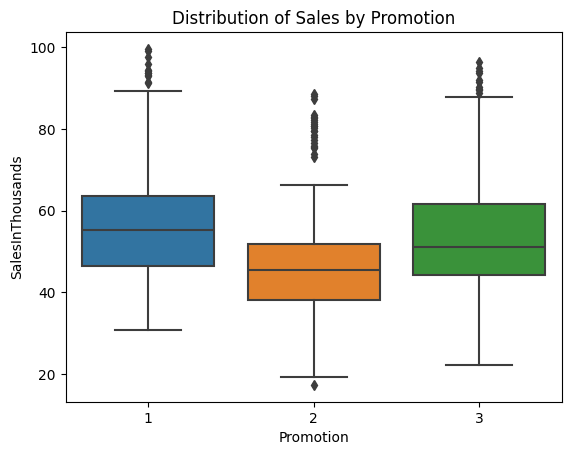

In [8]:
def analyze_categorical_levels(marketing_df):
    """
    Print the unique levels for each categorical variable in the DataFrame.
    """
    categorical_columns = ['MarketID', 'MarketSize', 'LocationID', 'Promotion', 'week']
    for col in categorical_columns:
        print(f"Levels for {col}:")
        print(marketing_df[col].unique())
        print("-" * 50)

def plot_outliers_by_promotion(marketing_df):
    """
    Plot the distribution of Sales (In Thousands) by Promotion to identify outliers.
    """
    sns.boxplot(x='Promotion', y='SalesInThousands', data=marketing_df)
    plt.title('Distribution of Sales by Promotion')
    plt.show()


analyze_categorical_levels(marketing_df)
plot_outliers_by_promotion(marketing_df)

In [9]:
# Calculate IQR
Q1 = marketing_df['SalesInThousands'].quantile(0.25)
Q3 = marketing_df['SalesInThousands'].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = marketing_df[(marketing_df['SalesInThousands'] < (Q1 - 1.5 * IQR)) | 
                        (marketing_df['SalesInThousands'] > (Q3 + 1.5 * IQR))]

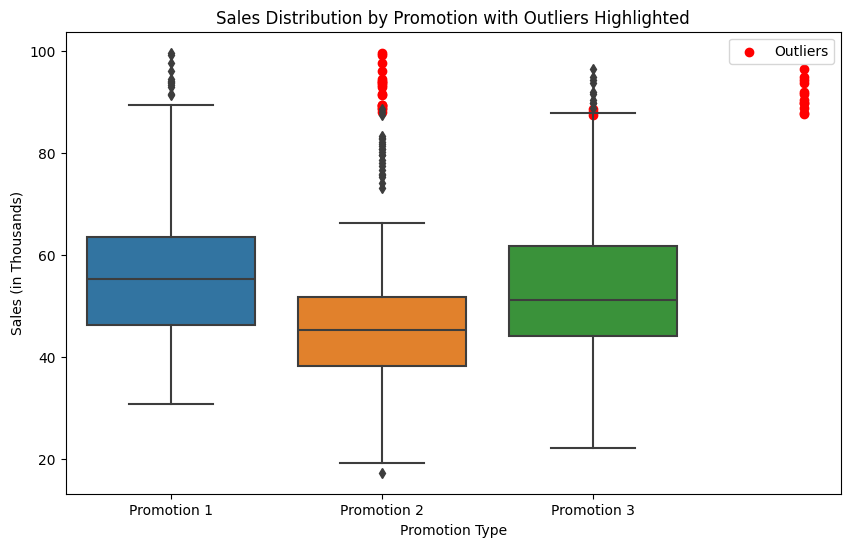

In [10]:
# Plotting box plot with outliers highlighted
plt.figure(figsize=(10, 6))
sns.boxplot(x='Promotion', y='SalesInThousands', data=marketing_df)
plt.scatter(outliers['Promotion'], outliers['SalesInThousands'], color='red', label='Outliers')
plt.title('Sales Distribution by Promotion with Outliers Highlighted')
plt.xlabel('Promotion Type')
plt.ylabel('Sales (in Thousands)')
plt.xticks(ticks=[0, 1, 2], labels=['Promotion 1', 'Promotion 2', 'Promotion 3'])
plt.legend()
plt.show()

Looking at the box plot we can see there are outliers so removing them so main advantage is  Enhanced Accuracy of the Model: By eliminating outliers, which have the potential to distort results, models may become more accurate. More Focus on Typical Patterns and Trends: Prevents the study from being distorted by extreme numbers, allowing for clearer insights. Superior Statistical Tests: Outliers can cause disruptions to the normalcy that many statistical tests presume. Adverse effects Information Loss: Significant variances or unusual occurrences may be represented by outliers. Bias: If outliers are a natural aspect of variability, eliminating them could generate bias. Results can be misinterpreted if outliers are removed without properly documenting the process.

To remove outliers from your data using the Interquartile Range (IQR) method, follow these steps: First, calculate the IQR by identifying the first quartile (Q1) and the third quartile (Q3), and then subtract Q1 from Q3. Next, determine the lower bound by subtracting 1.5 times the IQR from Q1, and the upper bound by adding 1.5 times the IQR to Q3. Finally, filter the data by removing any data points that fall outside these calculated bounds.

Calculate the IQR as 
IQR = Q3 − Q1

Determine the Bounds:

Lower bound = Q1 − 1.5 × IQR
Upper bound = Q3 + 1.5 × IQR

In [11]:
def remove_outliers(dataframe, col_name, promo_type):
    # Filter data for the specific promotion type
    df_p = dataframe[dataframe['Promotion'] == promo_type]
    
    # Calculate the first and third quartiles
    quartile1 = np.percentile(df_p[col_name], 25)
    quartile3 = np.percentile(df_p[col_name], 75)
    
    # Calculate the interquartile range (IQR)
    interquantile_range = quartile3 - quartile1
    
    # Determine the upper and lower limits for outliers
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    
    # Return the dataframe without outliers
    return df_p[(df_p[col_name] >= low_limit) & (df_p[col_name] <= up_limit)]

cleaned_data_p1 = remove_outliers(marketing_df, 'SalesInThousands', 1)
cleaned_data_p2 = remove_outliers(marketing_df, 'SalesInThousands', 2)
cleaned_data_p3 = remove_outliers(marketing_df, 'SalesInThousands', 3)

In [12]:
cleaned_data_p1.shape

(160, 7)

In [13]:
cleaned_data_p2.shape

(164, 7)

In [14]:
cleaned_data_p3.shape

(178, 7)

The code snippet concatenates three cleaned data frames, each representing sales data for different promotions, into a single data frame named clean_df. It uses pd.concat() to merge the data frames and reset_index() to ensure a continuous index without retaining the old index. Finally, it prints the first few rows of the combined data frame to verify the results.

In [15]:
clean_df = pd.concat([cleaned_data_p1, cleaned_data_p2, cleaned_data_p3], ignore_index=True)
clean_df.reset_index(drop=True, inplace=True)
clean_df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,3,12,1,1,44.54
1,1,Medium,3,12,1,2,37.94
2,1,Medium,3,12,1,3,45.49
3,1,Medium,3,12,1,4,34.75
4,1,Medium,7,15,1,1,42.92


comparing with the above dimenensions we got rid of 46 outliers giving us a cleaned data

In [16]:
clean_df.shape

(502, 7)

46 outliers were removed from the dataset

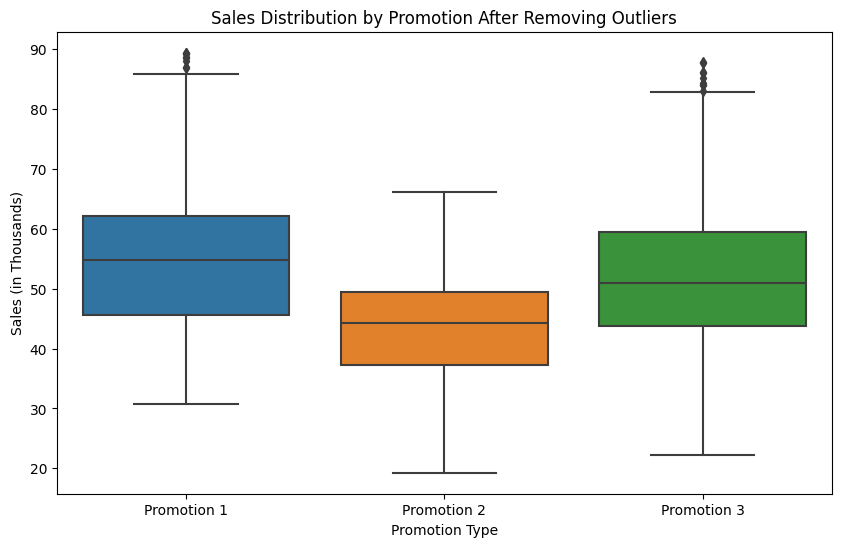

In [17]:
# Create a box plot for the cleaned data
plt.figure(figsize=(10, 6))
sns.boxplot(x='Promotion', y='SalesInThousands', data=clean_df)
plt.title('Sales Distribution by Promotion After Removing Outliers')
plt.xlabel('Promotion Type')
plt.ylabel('Sales (in Thousands)')
plt.xticks(ticks=[0, 1, 2], labels=['Promotion 1', 'Promotion 2', 'Promotion 3'])
plt.show()

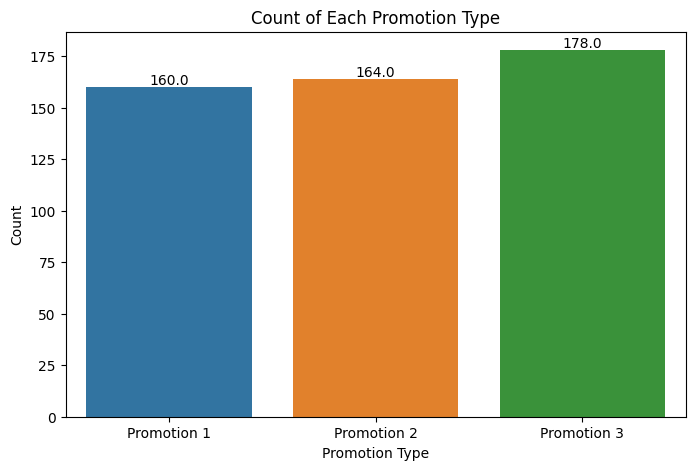

In [18]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='Promotion', data=clean_df)
plt.title('Count of Each Promotion Type')
plt.xlabel('Promotion Type')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=['Promotion 1', 'Promotion 2', 'Promotion 3'])

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.show()

The Q-Q plots generated for SalesInThousands across different Promotion types and MarketSize categories allow us to assess the normality of the sales data distribution. If the data points align closely with the reference line, the distribution is likely normal. This analysis helps compare the effectiveness of promotions across market sizes and identify any deviations from normality, indicating variability or inconsistencies in sales performance.

In [19]:
clean_df.groupby("Promotion").agg({"SalesInThousands": ["count", "mean", "median", "std"]})

SalesInThousands                              
                     count       mean  median        std
Promotion                                               
1                      160  55.345187  54.825  13.594556
2                      164  42.906098  44.300   9.057592
3                      178  53.297978  50.975  14.694229

Using `df.groupby(["Promotion", "MarketSize"]).agg({"SalesInThousands": ["count", "mean", "median", "std"]})` allows for a detailed analysis of sales performance across different promotions and market sizes. By grouping the data by both `Promotion` and `MarketSize` and calculating the count, mean, median, and standard deviation of `SalesInThousands`:

- **Count** provides the number of sales observations for each combination of promotion and market size, which helps in understanding the sample size for each scenario.
- **Mean** reveals the average sales amount for each promotion within each market size, offering insights into the effectiveness of promotions across varying market sizes.
- **Median** shows the middle value of sales, providing a robust measure of central tendency that is less affected by outliers, particularly useful in assessing typical sales performance.
- **Standard Deviation (std)** indicates the variability of sales data around the mean for each promotion and market size combination, highlighting differences in sales consistency.

These aggregated statistics enable a nuanced comparison of promotional effectiveness across different market sizes, helping to identify which promotions perform best in specific market conditions and guiding more informed marketing strategies.


In [20]:
clean_df.groupby(["Promotion", "MarketSize"]).agg({"SalesInThousands": ["count", "mean", "median", "std"]})

SalesInThousands                              
                                count       mean  median        std
Promotion MarketSize                                               
1         Large                    44  69.895682  64.500  13.004280
          Medium                   96  47.672604  47.425   8.067331
          Small                    20  60.162500  61.145   5.127279
2         Large                    41  49.185854  49.160   5.098969
          Medium                  107  39.317850  39.800   8.589968
          Small                    16  50.810625  51.600   5.869816
3         Large                    38  73.271316  80.990  13.623107
          Medium                  116  45.468879  46.295   8.091366
          Small                    24  59.514167  59.745   5.212687

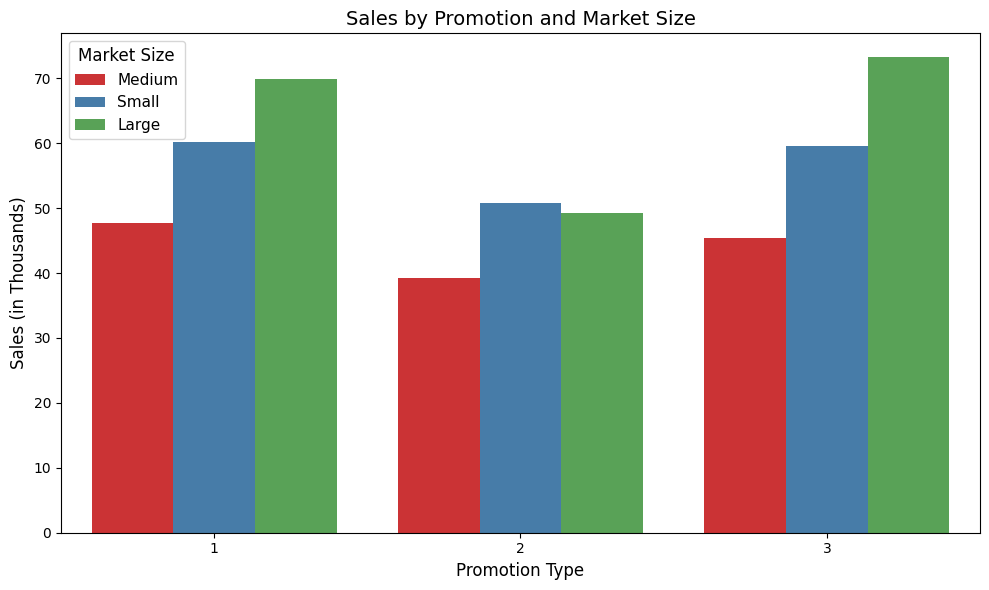

In [21]:
plt.figure(figsize=(10, 6))
sns.barplot(data=clean_df, x='Promotion', y='SalesInThousands', hue='MarketSize', errorbar=None, palette='Set1')
plt.title('Sales by Promotion and Market Size', fontsize=14)
plt.xlabel('Promotion Type', fontsize=12)
plt.ylabel('Sales (in Thousands)', fontsize=12)
plt.legend(title='Market Size', title_fontsize='12', fontsize='11')
plt.tight_layout()
plt.show()

from this we can see in each promotion promo 1 lost 12 sales in thousand and promo 2 lost 24 sales in thousand and promo 3 lost 10 sales in thousand

#  HYPOTHESIS FOR A/B TESTING 

ANOVA is the preferred statistical test for comparing the means of multiple groups, such as different promotion types, because it efficiently assesses whether there are significant differences among group means simultaneously. Unlike t-tests, which are limited to comparing two groups at a time, ANOVA can handle three or more groups without increasing the risk of Type I error. This makes it ideal for analyzing the impact of various promotions on sales performance, allowing for a comprehensive understanding of their effects in one test.

**Hypotheses**
1. H0: M1 = M2 = M3 There is no difference between promotion averages
2. H1: M1 != M2 = M3 At least one of the promotion averages is different

Before performing ANOVA on your sales data across different promotions, first check the assumptions: ensure that the sales data for each promotion is normally distributed and that the variances across the groups are equal.

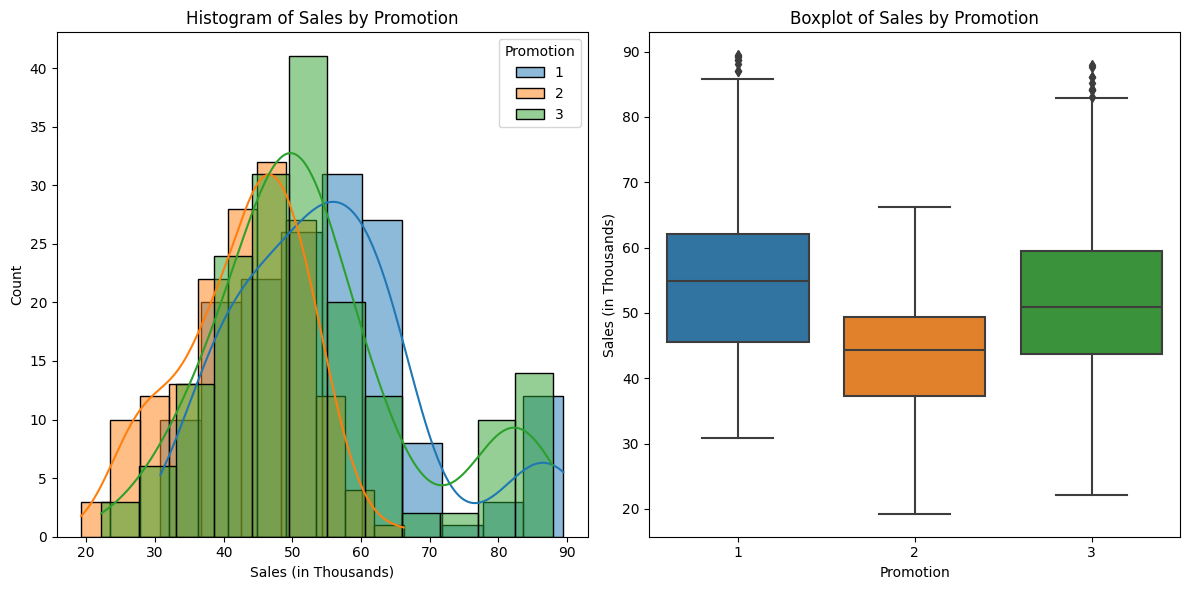

In [22]:
plt.figure(figsize=(12, 6))

# Histogram for normality check
plt.subplot(1, 2, 1)
for promotion in clean_df['Promotion'].unique():
    sns.histplot(clean_df[clean_df['Promotion'] == promotion]['SalesInThousands'], kde=True, label=str(promotion))
plt.title('Histogram of Sales by Promotion')
plt.xlabel('Sales (in Thousands)')
plt.legend(title='Promotion')

# Boxplot for homogeneity of variances check
plt.subplot(1, 2, 2)
sns.boxplot(x='Promotion', y='SalesInThousands', data=clean_df)
plt.title('Boxplot of Sales by Promotion')
plt.xlabel('Promotion')
plt.ylabel('Sales (in Thousands)')
plt.tight_layout()
plt.show()

/Users/pawanbtw/anaconda3/lib/python3.10/site-packages/statsmodels/graphics/gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


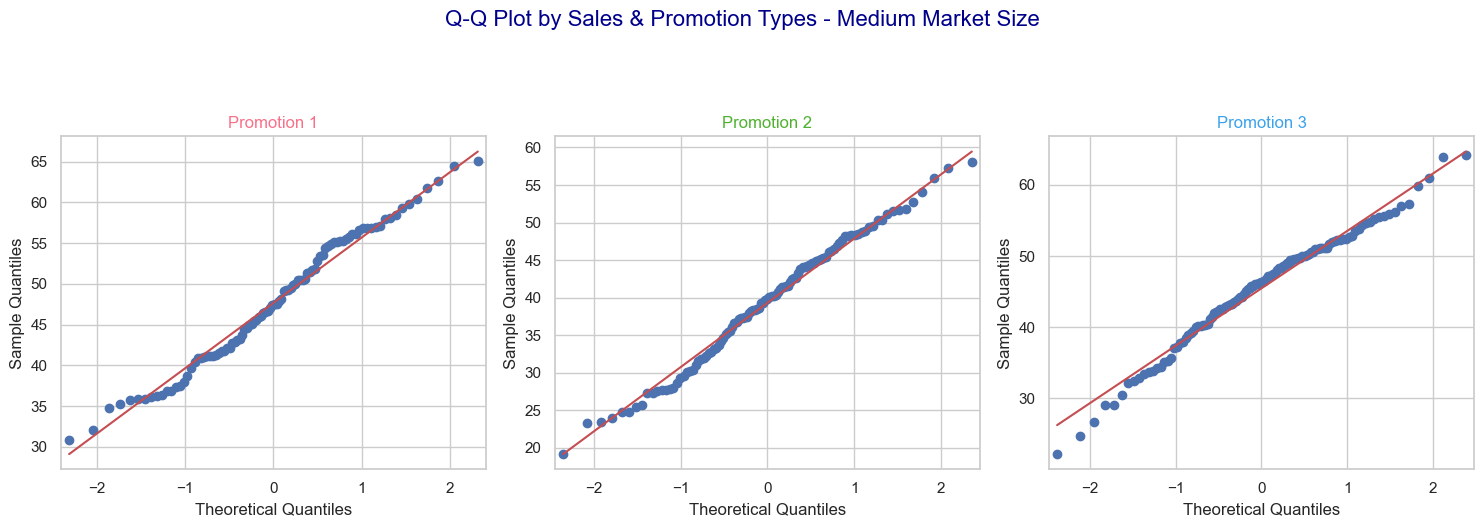

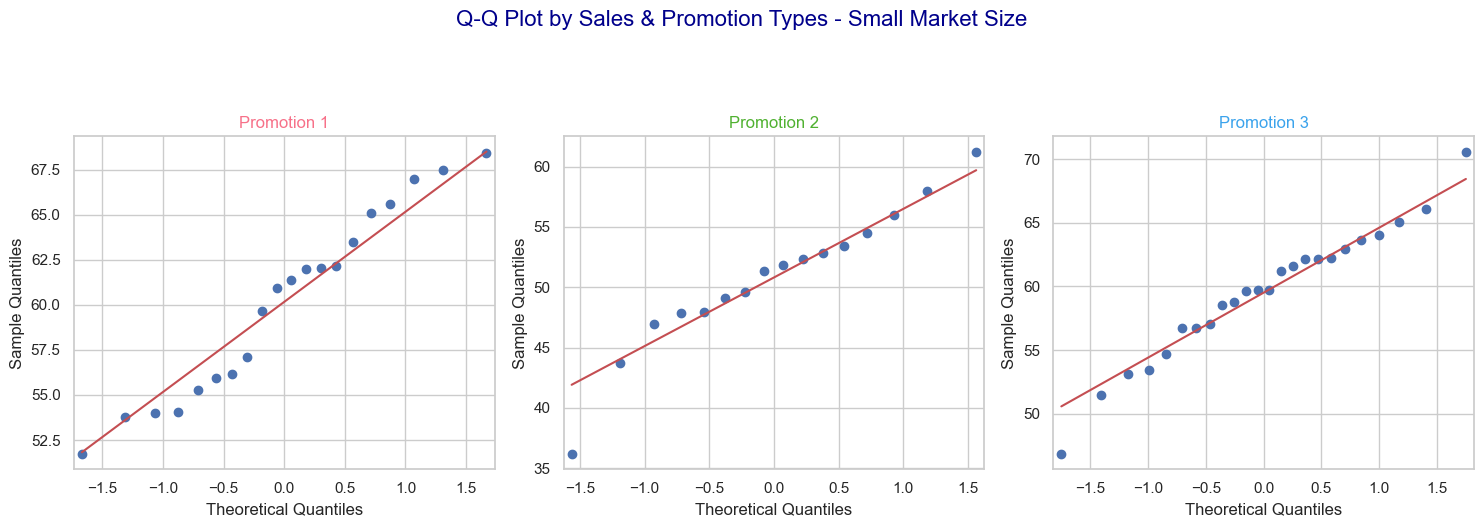

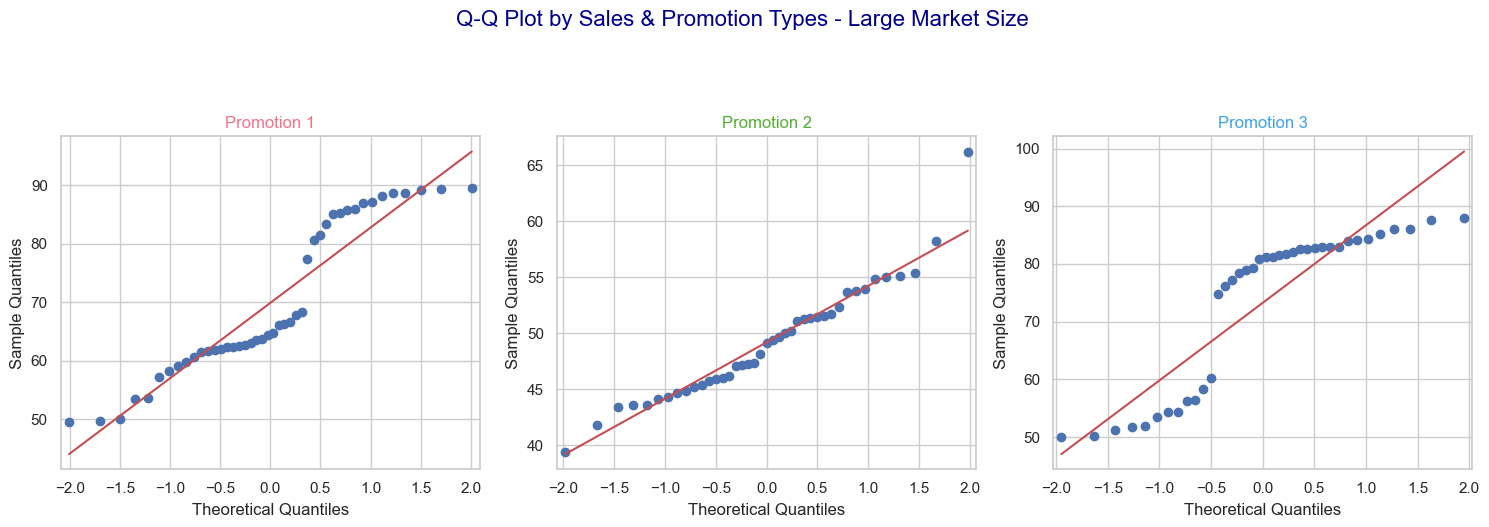

In [23]:
sns.set(style="whitegrid")
colors = sns.color_palette("husl", 3)  

market_size = clean_df["MarketSize"].unique()

for market in market_size:
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Q-Q Plot by Sales & Promotion Types - {market} Market Size', x=0.5, y=1.05, fontsize=16, color="darkblue")
    
    qqplot(clean_df[(clean_df["Promotion"] == 1) & (clean_df["MarketSize"] == market)]["SalesInThousands"], line="s", ax=axs[0], color=colors[0])
    qqplot(clean_df[(clean_df["Promotion"] == 2) & (clean_df["MarketSize"] == market)]["SalesInThousands"], line="s", ax=axs[1], color=colors[1])
    qqplot(clean_df[(clean_df["Promotion"] == 3) & (clean_df["MarketSize"] == market)]["SalesInThousands"], line="s", ax=axs[2], color=colors[2])
    
    axs[0].set_title("Promotion 1", fontsize=12, color=colors[0])
    axs[1].set_title("Promotion 2", fontsize=12, color=colors[1])
    axs[2].set_title("Promotion 3", fontsize=12, color=colors[2])
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


The Q-Q plots generated for `SalesInThousands` across different `Promotion` types and `MarketSize` categories allow us to assess the normality of the sales data distribution. If the data points align closely with the reference line, the distribution is likely normal. This analysis helps compare the effectiveness of promotions across market sizes and identify any deviations from normality, indicating variability or inconsistencies in sales performance.

Using `df.groupby("Promotion").agg({"SalesInThousands": ["count", "mean", "median", "std"]})` helps in evaluating the effectiveness of different promotions by aggregating key statistics for `SalesInThousands`. By grouping the data by `Promotion` and calculating the count, mean, median, and standard deviation of sales:

- **Count** provides the number of observations for each promotion, which helps in understanding the sample size.
- **Mean** shows the average sales amount, offering insight into the overall effectiveness of each promotion.
- **Median** provides the middle value of sales, which is useful for understanding the central tendency, especially if the data is skewed.
- **Standard Deviation (std)** measures the variability of sales, indicating how spread out the sales figures are around the mean.

These metrics collectively offer a comprehensive view of how each promotion performs and how sales data is distributed, aiding in informed decision-making about which promotion strategies are more effective.

Based on the Q-Q Plot by Sales & Promotion Types we can see that data is not distributed normally. 

## Shapiro-Wilk Test and Levene's Test

Shapiro-Wilk Test: We are using this test to assess the normality of your data. If the p-value is greater than 0.05, the data is likely normally distributed.

Levene's Test: This test is used to check the homogeneity of variances across groups. A p-value greater than 0.05 suggests that the variances are equal.

In [24]:
# Shapiro-Wilk test for normality
shapiro_results = {promotion: stats.shapiro(clean_df[clean_df['Promotion'] == promotion]['SalesInThousands']) for promotion in clean_df['Promotion'].unique()}

# Levene's test for homogeneity of variances
levene_test = stats.levene(clean_df[clean_df['Promotion'] == 1]['SalesInThousands'], 
                             clean_df[clean_df['Promotion'] == 2]['SalesInThousands'], 
                             clean_df[clean_df['Promotion'] == 3]['SalesInThousands'])
shapiro_results, levene_test

({1: ShapiroResult(statistic=0.9375624656677246, pvalue=1.7683266833046218e-06),
  2: ShapiroResult(statistic=0.9788514971733093, pvalue=0.013023082166910172),
  3: ShapiroResult(statistic=0.9297983050346375, pvalue=1.3668353915363696e-07)},
 LeveneResult(statistic=8.749248262971406, pvalue=0.00018422783404348003))

The results from your tests show that the Shapiro-Wilk Test for normality yields p-values of 
1.77×10^−6 for Promotion 1, 0.013 for Promotion 2, and 1.37×10^−7 for Promotion 3. Since all p-values are less than 0.05, the data for each promotion does not follow a normal distribution. Additionally, Levene's Test for homogeneity of variances has a p-value of 0.00018, indicating that the variances across the groups are not equal. As a result, the assumptions for ANOVA are not fully met, so you might consider using a non-parametric test like the Kruskal-Wallis test, which doesn't require normality or equal variances.

Since the assumptions for ANOVA are not met, you can use the Kruskal-Wallis test, a non-parametric alternative that doesn't require normality or equal variances.

In [25]:
# Perform Kruskal-Wallis test
kruskal_result = kruskal(
    clean_df[clean_df['Promotion'] == 1]['SalesInThousands'],
    clean_df[clean_df['Promotion'] == 2]['SalesInThousands'],
    clean_df[clean_df['Promotion'] == 3]['SalesInThousands']
)
print(kruskal_result)

KruskalResult(statistic=80.06537463352375, pvalue=4.111732025490055e-18)


### Why Perform a Dunn Test After the Kruskal-Wallis Test?

After conducting the Kruskal-Wallis test, which indicates whether there is a statistically significant difference among the groups, we still don’t know which specific groups are different from each other. 

The Dunn test is a post-hoc analysis that helps to identify **which pairs of groups** are significantly different. It’s necessary when the Kruskal-Wallis test returns a significant result, as it helps to pinpoint the exact groups with differences while adjusting for multiple comparisons to control for Type I error.

In [26]:
# Perform Dunn's test
dunn_result = posthoc_dunn(clean_df, val_col='SalesInThousands', group_col='Promotion', p_adjust='bonferroni')
dunn_result

,1,2,3
1,1.000000e+00,6.508986e-17,1.550190e-01
2,6.508986e-17,1.000000e+00,4.383361e-11
3,1.550190e-01,4.383361e-11,1.000000e+00


From your Dunn's test results:
Promotion 1 vs 2: Significant difference (p-value = 
6.51×10^−17
Promotion 2 vs 3: Significant difference (p-value = 
4.38×10^−11
Promotion 1 vs 3: No significant difference (p-value = 0.155).
2. Determine Effectiveness
Promotion 2 shows significant differences from both Promotions 1 and 3, indicating it has a distinct impact.
Since Promotions 1 and 3 are not significantly different, Promotion 2 might be more effective if it leads to higher sales.

In [27]:
means = clean_df.groupby('Promotion')['SalesInThousands'].mean()
print(means)

Promotion
1    55.345187
2    42.906098
3    53.297978
Name: SalesInThousands, dtype: float64


In [28]:
# Convert categorical variables to dummy variables
df = pd.get_dummies(clean_df, drop_first=True)

# Define features and target
X = df.drop('SalesInThousands', axis=1)
y = df['SalesInThousands']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape , X_test.shape , y_train.shape , y_test.shape

((401, 7), (101, 7), (401,), (101,))

# K-Nearest Neighbors

In [29]:
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_test, y_test) * 100, 2)
print(f'K-Nearest Neighbors Accuracy: {acc_knn}%')

K-Nearest Neighbors Accuracy: 71.17%


# Decision Tree

In [30]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)

Y_pred = dt.predict(X_test)
acc_dt = round(dt.score(X_test, y_test) * 100, 2)
print(f'Decision Tree Accuracy: {acc_dt}%')

Decision Tree Accuracy: 58.45%


# Gradient Boosting Regressor

In [31]:
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

Y_pred = gbr.predict(X_test)
acc_gbr = round(gbr.score(X_test, y_test) * 100, 2)
print(f'Gradient Boosting Regressor Accuracy: {acc_gbr}%')

Gradient Boosting Regressor Accuracy: 76.44%


# Random Forest

In [32]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

Y_pred = rf.predict(X_test)
acc_rf = round(rf.score(X_test, y_test) * 100, 2)
print(f'Random Forest Accuracy: {acc_rf}%')

Random Forest Accuracy: 70.78%


# Linear regression

In [33]:
lireg = LinearRegression()
lireg.fit(X_train, y_train)

Y_pred = lireg.predict(X_test)
acc_lir = round(lireg.score(X_test, y_test) * 100, 2)
print(f'Linear Regression Accuracy: {acc_lir}%')

Linear Regression Accuracy: 27.53%


In [34]:
accuracy_scores = {
    'K-Nearest Neighbors': acc_knn,
    'Decision Tree': acc_dt,
    'Gradient Boosting': acc_gbr,
    'Random Forest': acc_rf,
    'Linear Regression': acc_lir
}

ranked_models = sorted(accuracy_scores.items(), key=lambda x: x[1], reverse=True)
for model, score in ranked_models:
    print(f'{model}: {score}%')

Gradient Boosting: 76.44%
K-Nearest Neighbors: 71.17%
Random Forest: 70.78%
Decision Tree: 58.45%
Linear Regression: 27.53%


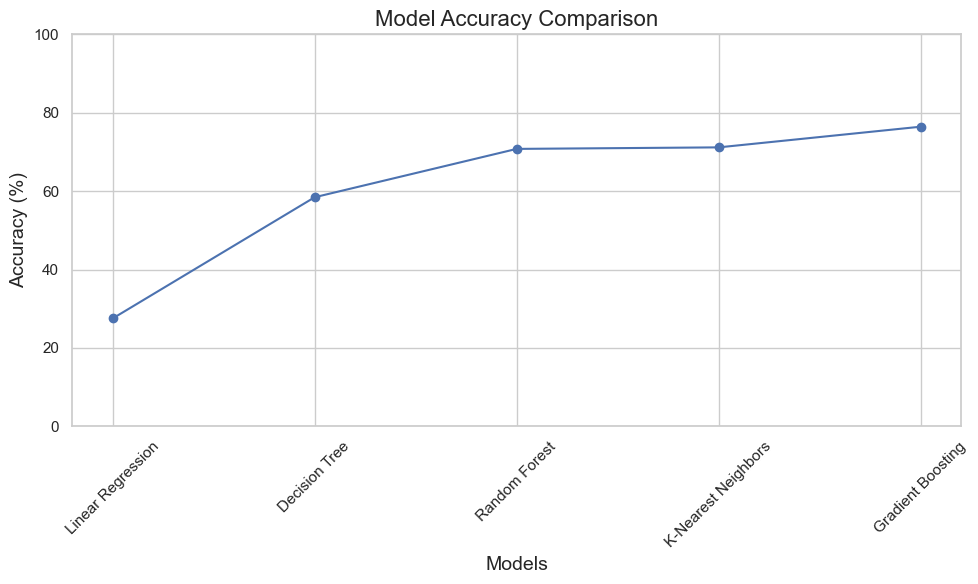

In [35]:
accuracy_scores = {
    'K-Nearest Neighbors': acc_knn,
    'Decision Tree': acc_dt,
    'Gradient Boosting': acc_gbr,
    'Random Forest': acc_rf,
    'Linear Regression': acc_lir
}

ranked_models = sorted(accuracy_scores.items(), key=lambda x: x[1])
model_names = [model[0] for model in ranked_models]
scores = [model[1] for model in ranked_models]

plt.figure(figsize=(10, 6))
plt.plot(model_names, scores, marker='o', linestyle='-', color='b')
plt.title('Model Accuracy Comparison', fontsize=16)
plt.xlabel('Models', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.ylim(0, 100)  
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Model Performance Analysis of Regression Techniques

The following analysis presents the accuracy of various regression models used to predict sales:

1. **Gradient Boosting**: **76.44%**
   - This model demonstrates the highest accuracy, indicating its effectiveness in capturing complex relationships within the data.

2. **K-Nearest Neighbors**: **71.17%**
   - With solid performance, KNN is effective in scenarios where local patterns are significant, making it a useful model for regression tasks.

3. **Random Forest**: **70.78%**
   - As an ensemble method, Random Forest performs well by averaging multiple decision trees, thus reducing overfitting and handling various data distributions effectively.

4. **Decision Tree**: **58.45%**
   - While easy to interpret, the decision tree's lower accuracy suggests it may be too simplistic for this dataset, capturing some trends but failing to generalize well.

5. **Linear Regression**: **27.53%**
   - This model shows the lowest accuracy, indicating that a simple linear approach is insufficient for capturing the underlying patterns in the data.

### Conclusion

The analysis highlights that **Gradient Boosting** is the most appropriate model for predicting sales, while **Linear Regression** is not suitable for this dataset. This ranking can guide decision-making in model selection for future predictions.

DTR score:: 0.73 (0.031)
RFR score:: 0.83 (0.011)
XGBR score:: 0.78 (0.026)
LIRE score:: 0.40 (0.059)
CAT score:: 0.84 (0.012)

Model Accuracy Scores:
DTR: 0.73
RFR: 0.83
XGBR: 0.78
LIRE: 0.40
CAT: 0.84


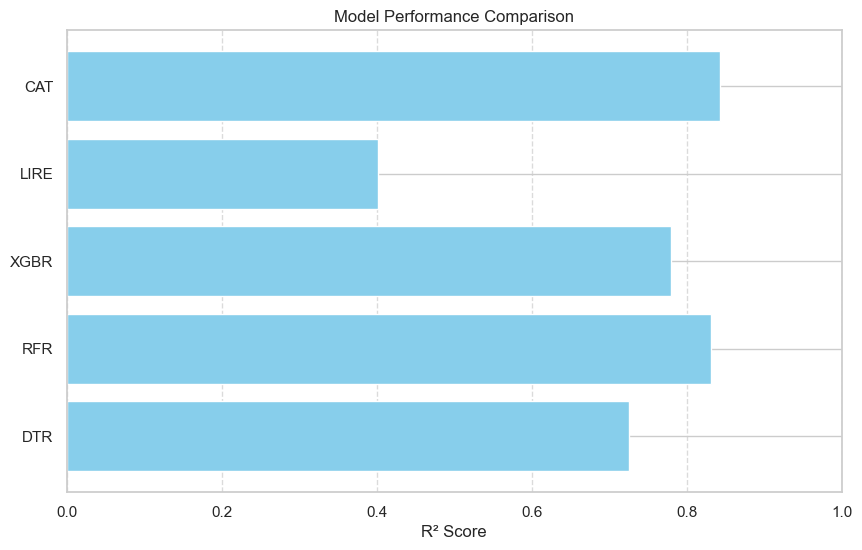

In [36]:
models = {
    'DTR': DecisionTreeRegressor(),
    'RFR': RandomForestRegressor(),
    'XGBR': XGBRegressor(),
    'LIRE': LinearRegression(),
    'CAT': CatBoostRegressor(verbose=False)
}

scores = {}
for name, model in models.items():
    kfold = RepeatedKFold(n_splits=2, n_repeats=3)
    score = cross_val_score(model, X_train, y_train, scoring='r2', cv=kfold, n_jobs=-1)
    scores[name] = np.mean(score)
    print("%s score:: %.2f (%.3f)" % (name, np.mean(score), np.std(score)))
    
print("\nModel Accuracy Scores:")
for model_name, score in scores.items():
    print(f"{model_name}: {score:.2f}")

model_names = list(scores.keys())
model_scores = list(scores.values())

plt.figure(figsize=(10, 6))
plt.barh(model_names, model_scores, color='skyblue')
plt.xlabel('R² Score')
plt.title('Model Performance Comparison')
plt.xlim(0, 1)  # R² score ranges from 0 to 1
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

## Conclusion 2
### Summary of Model Evaluation

In this section, we evaluate the performance of several regression models:

- **Decision Tree Regressor (DTR)**
- **Random Forest Regressor (RFR)**
- **XGBoost Regressor (XGBR)**
- **Linear Regression (LIRE)**
- **CatBoost Regressor (CAT)**

### Process Overview

1. **Model Definition**: A dictionary of regression models is created.
2. **Cross-Validation**: Each model is evaluated using `RepeatedKFold` cross-validation to ensure reliable performance metrics.
3. **R² Score Calculation**: The mean R² score and standard deviation are computed for each model.
4. **Output**: The scores are printed for comparison.

This process helps identify the best-performing regression model for our dataset.

The best model is **Random Forest Regressor (RFR)** and **CatBoost Regressor (CAT)** with an accuracy score of **0.83**.